# Early Stopping Of Stochastic Gradient Descent

In this notebook I will practice the application of early stopping when using optimization techniques like Stochastic Gradient Descent. I draw much of the inspiration for this notebook from the official [scikit-learn documentation](https://scikit-learn.org/stable/auto_examples/linear_model/plot_sgd_early_stopping.html). 

Early stopping is a method that allows to specify an arbitrary number of training epochs and stop the training once the model performance stops improving on the validation set. Therefore we can avoid overfitting in some cases, e.g. when training complex models like a neural net. In all other cases it will at least help to minimize the fit time of the algorithm and therefore increase efficiency.

In [9]:
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.linear_model import SGDClassifier
from sklearn.utils._testing import ignore_warnings
from sklearn.exceptions import ConvergenceWarning
import time

I will use the popular [mnist_784](https://www.openml.org/d/554) dataset for the purpose of this notebook. It is a database of handwritten digits with 784 features and the goal is to provide the correct class for each image.

In [3]:
# Fetch mnist data
X, y = fetch_openml('mnist_784', version=1, return_X_y=True, as_frame=False)

To make this task a binary classification problem (and therefore even simpler), we will filter the dataset to the digits `0` and `5`. And our goal is to predict for each digit whether it is a `5` or not.

In [4]:
# Filter the dataset and recreate label
mask = np.isin(y, ['0', '5'])
X, y = X[mask], y[mask]
y = np.where(y == '5', 1, 0)

Let's take a look on some  samples.

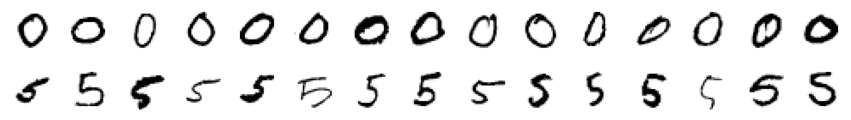

In [5]:
# Draw random samples for each class
sample0_idx = np.random.choice(np.argwhere(y==0).squeeze(), 15)
sample5_idx = np.random.choice(np.argwhere(y==1).squeeze(), 15)

fig = plt.figure(figsize=(15, 2))
for i, idx in enumerate(np.r_[sample0_idx, sample5_idx]):
    ax = fig.add_subplot(2, 15, i+1)
    ax.imshow(X[idx].reshape(28, 28), cmap='Greys') # Reshape before plotting
    ax.set_axis_off()
plt.show()

Next I compare the `train_score`, `test_score` and the `fit_time` of three estimators for variant number of epochs (which we can control using the `max_iter` parameter). The first model will complete the full number of training epochs. The second one will stop once the training loss does not decrease by `tol` for several epochs. And for the third model we apply an early stopping procedure, meaning that the training stops once the validation score does not increase by `tol` for several epochs.

In [26]:
@ignore_warnings(category=ConvergenceWarning)
def fit_and_score(estimator, max_iter, X_train, X_test, y_train, y_test):
    """Fits estimator for given `max_iter` setting and 
    calculates train and test score"""
    
    # Set params
    estimator.set_params(max_iter=max_iter)
    estimator.set_params(random_state=0)
    
    # Fit and track fit time
    start = time.time()
    estimator.fit(X_train, y_train)
    fit_time = time.time() - start
    
    # Get scores
    train_score = estimator.score(X_train, y_train)
    test_score = estimator.score(X_test, y_test)
    
    return train_score, test_score, fit_time


# Make train test split
X_train, X_test, y_train, y_test = train_test_split(X, y)

# Initialize estimator objects
estimator_dict = {
    'No early stopping': SGDClassifier(tol = None),
    'Train loss': SGDClassifier(tol = 0.1),
    'Validation score': SGDClassifier(tol = 0.00001, early_stopping=True, validation_fraction=0.2)
}

# Create results list
results = []

# Fit model for each estimator - max_iter combination
for name, estimator in estimator_dict.items():
    for max_iter in np.arange(1, 100, 1):
        train_score, test_score, fit_time = fit_and_score(
            estimator, max_iter, X_train, X_test, y_train, y_test)
        # Store results
        results.append({'name': name, 'max_iter': max_iter, 'train_score': train_score, 
                        'test_score': test_score, 'fit_time': fit_time})
# Convert to dataframe
results = pd.DataFrame.from_records(results)

What we can see is that while the first model (`No early stopping`) completes all training epochs, the second model (`Train loss`) stops the training process in the ~60th epoch and the third model (`Validation score`) even further in the ~10th epoch. However, there seems to be no overfitting for neither model. In this specific case the major advantage of early stopping is therefore that we can reduce

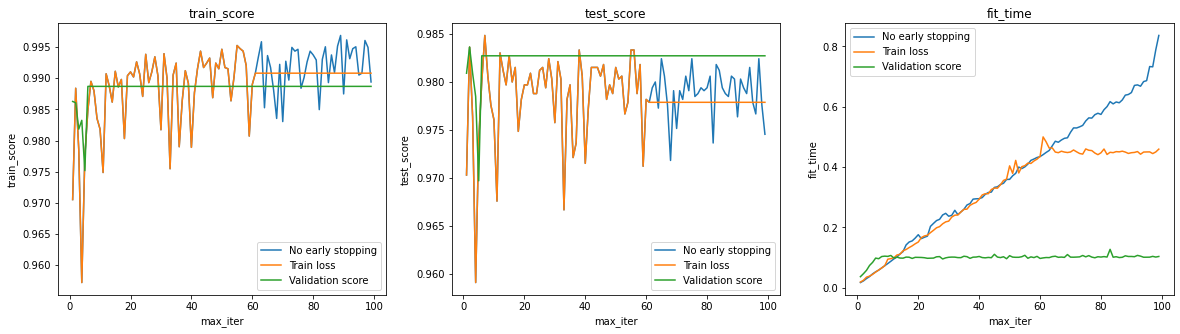

In [27]:
fig = plt.figure(figsize=(20, 5))

ax1 = fig.add_subplot(131)
ax1.set_title('train_score')
g = sns.lineplot(x = 'max_iter', y = 'train_score', hue = 'name', data = results, ax = ax1)
g.legend_.set_title(None)

ax2 = fig.add_subplot(132)
ax2.set_title('test_score')
g = sns.lineplot(x = 'max_iter', y = 'test_score', hue = 'name', data = results, ax = ax2)
g.legend_.set_title(None)

ax3 = fig.add_subplot(133)
ax3.set_title('fit_time')
g = sns.lineplot(x = 'max_iter', y = 'fit_time', hue = 'name', data = results, ax = ax3)
g.legend_.set_title(None)

plt.show()